In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import numpy as np
from numpy import savez_compressed
from numpy import load
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

from paths import dataset_paths
from helper_functions import create_list
from helper_functions import resize_and_keep_ratio
from helper_functions import crop_image
from helper_functions import load_and_split_data

In [4]:
def crop_image_triplet_loss(image, crop_width):
    """
    Crops an random part out of an image and display the cropped area
    
    Arguments:
        image: image in an numpy array format
        width: int value width desired crop width
        
    Return:
        Cropped image in an numpy array format
    """
    #Convert PIL Image object into numpy array
    img_array = np.array(image)
    #select random point on x-axis and crop the image
    x_max = img_array.shape[1] - crop_width
    x_1 = np.random.randint(0, x_max)
    x_2 = np.random.randint(0, x_max)
    crop_1 = img_array[0:crop_width, x_1: x_1 + crop_width]
    crop_2 = img_array[0:crop_width, x_2: x_2 + crop_width]

    return crop_1, crop_2

In [5]:
def create_triplet_dataset(dataset_size, height, width, path, rgb=False):
    
    if rgb == True:
        #create empty arrays for rgb data
        anchors = np.zeros([dataset_size, height, width, 3])
        positives = np.zeros([dataset_size, height, width, 3])
        negatives = np.zeros([dataset_size, height, width, 3])
        y = np.zeros([dataset_size, 0])
    else: 
        #create empty arrays for grayscale data
        anchors = np.zeros([dataset_size, height, width, 1])
        positives = np.zeros([dataset_size, height, width, 1])
        negatives = np.zeros([dataset_size, height, width, 1])
        y = np.zeros([dataset_size, 0])
        
    i = 0
    
    while i < dataset_size:
        #Select two random folders for anchor/positive and negative samples and save the paths to lists
        list_anchor_positive, list_negative = random.sample(dataset_paths, 2)
        list_anchor_positive = create_list(list_anchor_positive)
        list_negative = create_list(list_negative)
        
        #load two images for anchor/positive and negative from disk and preprocess it
        image_anchor_positive = resize_and_keep_ratio(list_anchor_positive, height, rgb)
        image_negative = resize_and_keep_ratio(list_negative, height, rgb)
        
        #new cycle if one of the 2 loaded images is 0
        if image_anchor_positive == 0 or image_negative == 0:
            pass
        else:
            if rgb == True:
                anchor, positive = (crop_image_triplet_loss(image_anchor_positive, width))
                anchors[i] = anchor / 255.
                positives[i] = positive / 255.
                negatives[i] = (crop_image(image_negative, width)) / 255.
                y[i] = 0
                
            else:
                anchor, positive = (crop_image_triplet_loss(image_anchor_positive, width))
                anchors[i] = anchor / 255.
                positives[i] = positive / 255.
                negative[i] = (crop_image(image_negative, width)) / 255.
                y[i] = 0
        
            i += 1
        
    return[anchors, positives, negatives], y

In [6]:
%%time
x, y = create_triplet_dataset(15000, 224, 224, dataset_paths, rgb=True)

CPU times: user 2min 35s, sys: 1min 23s, total: 3min 59s
Wall time: 4min 4s


In [7]:
def save_triplet_arrays(x, y, sample_size, rgb=False):
    """
    Function for saving numpy arrays in numpy .npz format on disc
    
    Arguments:
        sample_size: Number of image pairs in int format
        x: x data as numpy array
        y: y data as numpy array
        rgb: npz extension if rgb or grayscale images
    
    Returns:
        Print statement if saving is successfull
    """
    if rgb == True:
        savez_compressed(f'npz_datasets/data_x_{sample_size}_rgb_triplet.npz', x)
        savez_compressed(f'npz_datasets/data_y_{sample_size}_rgb_triplet.npz', y)
    else:
        savez_compressed(f'npz_datasets/data_x_{sample_size}_gray_triplet.npz', x)
        savez_compressed(f'npz_datasets/data_y_{sample_size}_gray_triplet.npz', y)
    print("saved successfully")

In [8]:
sample_size = 15000
save_triplet_arrays(x, y, sample_size, rgb=True)

saved successfully


In [11]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_15000_rgb_triplet.npz", "npz_datasets/data_y_15000_rgb_triplet.npz", split_size=80, batch_size=128, triplet=True)

CPU times: user 1min 20s, sys: 19.1 s, total: 1min 39s
Wall time: 1min 39s


In [34]:
train_dataset.take(1)

<TakeDataset shapes: (((None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)), (None, 0)), types: ((tf.float64, tf.float64, tf.float64), tf.float64)>

In [12]:
def triplet_loss_l2(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anc - pos, 2), 1, keepdims=True))
        distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anc - neg, 2), 1, keepdims=True))
        return tf.reduce_mean(tf.maximum(distance1 - distance2 + alpha, 0.))
    return loss

In [13]:
def triplet_loss_cosine(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.keras.losses.cosine_similarity(anc, pos)
        distance2 = tf.keras.losses.cosine_similarity(anc, neg)
        return tf.keras.backend.clip(distance1 - distance2 + alpha, 0., None)
    return loss

In [14]:
img_width = 224
img_height = 224

In [125]:
#Set seed
tf.random.set_seed(42)

emb_size = 512

base_model = tf.keras.applications.vgg16.VGG16(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(emb_size, activation="relu")(x)
outputs = keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1))(x)

base_model_vgg_16 = keras.models.Model(inputs, outputs)

In [126]:
input_anchor = keras.layers.Input(shape=(224,224,3))
input_positive = keras.layers.Input(shape=(224,224,3))
input_negative = keras.layers.Input(shape=(224,224,3))

embed_anchor = base_model_vgg_16(input_anchor)
embed_positive = base_model_vgg_16(input_positive)
embed_negative = base_model_vgg_16(input_negative)

out = keras.layers.concatenate([embed_anchor, embed_positive, embed_negative], axis=1)

In [127]:
model_vgg_16 = keras.models.Model([input_anchor, input_positive, input_negative], out)

In [128]:
model_vgg_16.compile(loss=triplet_loss_l2(alpha=0.2, emb_dim=emb_size), optimizer="Adam")

In [129]:
history_model_vgg_16 = model_vgg_16.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
94/94 [==============================] - 39s 406ms/step - loss: 0.0294 - val_loss: 0.0196
Epoch 2/10
94/94 [==============================] - 38s 405ms/step - loss: 0.0166 - val_loss: 0.0137
Epoch 3/10
94/94 [==============================] - 38s 406ms/step - loss: 0.0146 - val_loss: 0.0126
Epoch 4/10
94/94 [==============================] - 38s 406ms/step - loss: 0.0120 - val_loss: 0.0135
Epoch 5/10
94/94 [==============================] - 38s 407ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 6/10
94/94 [==============================] - 38s 406ms/step - loss: 0.0094 - val_loss: 0.0108
Epoch 7/10
94/94 [==============================] - 39s 407ms/step - loss: 0.0088 - val_loss: 0.0119
Epoch 8/10
94/94 [==============================] - 39s 407ms/step - loss: 0.0085 - val_loss: 0.0119
Epoch 9/10
94/94 [==============================] - 39s 408ms/step - loss: 0.0076 - val_loss: 0.0098
Epoch 10/10
94/94 [==============================] - 39s 408ms/step - loss: 0.0068 - val_lo

In [130]:
results = model_vgg_16.predict(test_dataset)

In [25]:
cosine_similarity = metrics.CosineSimilarity()

In [132]:
for i in range(20):
    anchor = results[i][:emb_size]
    positive = results[i][emb_size:emb_size*2]
    negative = results[i][emb_size*2:]
    distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anchor - positive, 2), axis=-1)).numpy()
    distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anchor - negative, 2), axis=-1)).numpy()
    #positive_similarity = (cosine_similarity(anchor, positive)).numpy()
    #negative_similarity = (cosine_similarity(anchor, negative)).numpy()
    #print(positive_similarity)
    #print(negative_similarity)
    print(f"positve: {distance1}")
    print(f"negative: {distance2}")
    print("------------------------")

positve: 0.26056528091430664
negative: 0.8722168803215027
------------------------
positve: 0.25029072165489197
negative: 1.0435330867767334
------------------------
positve: 0.3676890730857849
negative: 1.0440152883529663
------------------------
positve: 0.6030675768852234
negative: 0.6117472052574158
------------------------
positve: 0.27874669432640076
negative: 0.8769677877426147
------------------------
positve: 0.45442497730255127
negative: 1.3094731569290161
------------------------
positve: 0.12623664736747742
negative: 0.8270788788795471
------------------------
positve: 0.35968220233917236
negative: 1.1262309551239014
------------------------
positve: 0.32070085406303406
negative: 0.45814943313598633
------------------------
positve: 0.22830048203468323
negative: 0.8598271608352661
------------------------
positve: 0.3318183720111847
negative: 1.307089924812317
------------------------
positve: 0.2261589765548706
negative: 1.0852826833724976
------------------------
positve:

In [79]:
sample = next(iter(test_dataset))
anchor = np.expand_dims(sample[0][0][0], axis=0)
positive = np.expand_dims(sample[0][1][0], axis=0)
negative = np.expand_dims(sample[0][2][0], axis=0)

In [80]:
preds = model_vgg_16.predict([anchor, positive, negative])

In [81]:
anchor_embed = preds[0][:1024]
positive_embed = preds[0][1024:1024*2]
negative_embed = preds[0][1024*2:]

In [104]:
distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anchor_embed - positive_embed, 2), axis=-1))
distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anchor_embed - negative_embed, 2), axis=-1))

In [106]:
print(distance1)
print(distance2)

tf.Tensor(0.007600005, shape=(), dtype=float32)
tf.Tensor(0.012971936, shape=(), dtype=float32)


In [192]:
sample[0][0].shape

TensorShape([128, 224, 224, 3])

In [193]:
sample[0][1].shape

TensorShape([128, 224, 224, 3])

In [194]:
sample[0][2].shape

TensorShape([128, 224, 224, 3])

In [77]:
import matplotlib.pyplot as plt

In [195]:
anchor = sample[0][0][0]
positive = sample[0][1][0]
negative = sample[0][2][0]

In [196]:
anchor_embed = base_model_vgg_16(np.expand_dims(anchor, axis=0))
positive_embed = base_model_vgg_16(np.expand_dims(positive, axis=0))
negative_embed = base_model_vgg_16(np.expand_dims(negative, axis=0))

In [197]:
from tensorflow.keras import metrics
cosine_similarity = metrics.CosineSimilarity()

In [198]:
positive_similarity = (cosine_similarity(anchor_embed, positive_embed)).numpy()
negative_similarity = (cosine_similarity(anchor_embed, negative_embed)).numpy()

In [199]:
print(positive_similarity)
print(negative_similarity)

0.98693264
0.5168765


In [116]:
print(positive_similarity)
print(negative_similarity)

0.8177115
0.42451617


In [200]:
for i in range(10):
    anchor = sample[0][0][i]
    positive = sample[0][1][i]
    negative = sample[0][2][i]
    
    anchor_embed = base_model_vgg_16(np.expand_dims(anchor, axis=0))
    positive_embed = base_model_vgg_16(np.expand_dims(positive, axis=0))
    negative_embed = base_model_vgg_16(np.expand_dims(negative, axis=0))
    
    positive_similarity = (cosine_similarity(anchor_embed, positive_embed)).numpy()
    negative_similarity = (cosine_similarity(anchor_embed, negative_embed)).numpy()
    
    print("positive: ", positive_similarity)
    print("negative: ", negative_similarity)

positive:  0.6735619
negative:  0.5168765
positive:  0.5825464
negative:  0.6322687
positive:  0.6720594
negative:  0.6494194
positive:  0.675735
negative:  0.67457324
positive:  0.7023089
negative:  0.70358056
positive:  0.7126394
negative:  0.71612483
positive:  0.7314385
negative:  0.7372568
positive:  0.74218076
negative:  0.72195804
positive:  0.73028135
negative:  0.7010739
positive:  0.7145568
negative:  0.71693486


In [124]:
import matplotlib.pyplot as plt

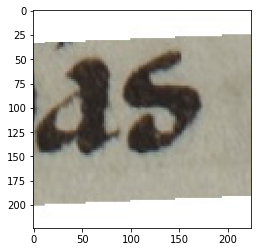

In [131]:
plt.imshow(sample[0][0][3])